In [40]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy as sp
from scipy.special import erf
import math
import networkx as nx

from utils import *
from intersection_graph import *
from scipy.integrate import quad

# Activation Functions

In [2]:
def RELU(x):
    return np.maximum(x, 0)

def ABS(x):
    return np.abs(x)

def GELU(x):
    return 0.5 * x * (1.0 + erf(x / np.sqrt(2.0)))

def LINEAR(x):
    return x

def BINARY(x):
    return np.where(x >= 0, 1, 0)

def SIGMOID(x):
    return 1 / (1 + np.exp(-x))

def TANH(x):
    return np.tanh(x)

def SOFTSIGN(x):
    return x / (1 + np.abs(x))

def SOFTPLUS(x):
    return np.log1p(np.exp(x))

def LEAKY_RELU(x):
    return np.where(x > 0, x, 0.01 * x)

def SILU(x):
    return x / (1 + np.exp(-x))

def ELISH(x):
    return np.where(x < 0,
                    (np.exp(x) - 1) / (1 + np.exp(-x)),
                    x / (1 + np.exp(-x)))

def GAUSSIAN(x):
    return np.exp(-x**2)

def SINUSOIDAL(x):
    return np.sin(x)

# Tanh

In [3]:
M = m_matrix(5)
Q, labels = q_matrix(5)
D = d_matrix(5)

byL = indices_by_rep(labels)


blocks = {}
for Ls in byL:
    for Lk in byL:
        B = activation_func_block(Q, D, byL, Ls, Lk, activation_func=TANH)
        if not is_zero_numeric(B, tol=1e-12):
            blocks[(Ls, Lk)] = B
        else:
            blocks[(Ls, Lk)] = sp.Matrix.zeros(1, 1)


i = 0
print(f"{list(blocks.keys())[i][0]} -> {list(blocks.keys())[i][1]}")
blocks[list(blocks.keys())[i]]

L_0 -> L_0


Matrix([[0.761594155955765]])

In [4]:
Ls = "L_0"
Lk = "L_2"

activation_func_block(Q, D, byL, Ls, Lk, activation_func=TANH)

Matrix([
[0],
[0]])

$\text{Example}: C_n$

c:\Users\Mani\Desktop\Coding\Masters\equivarient_NN\intersection_graph.py:134: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


"neato" with args ['-Tdot', 'C:\\Users\\Mani\\AppData\\Local\\Temp\\tmpkf10tw29\\tmpw1damazi'] returned code: 3221225477

stdout, stderr:
 b''
b''



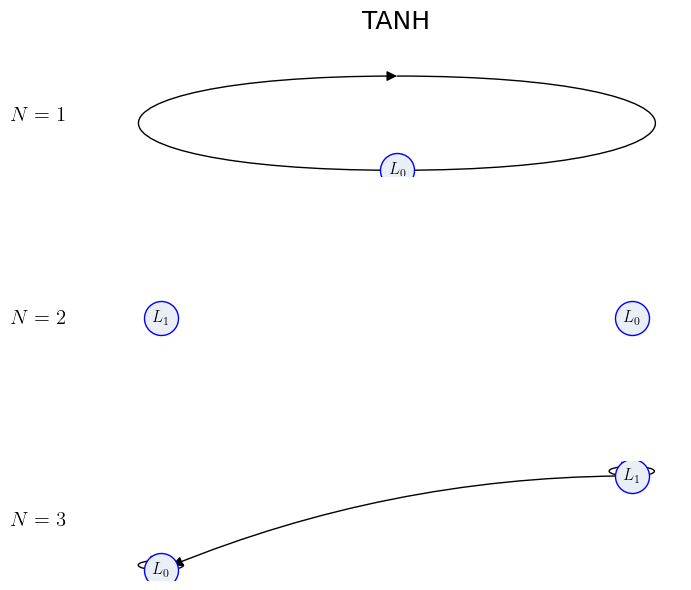

In [5]:
N = 3
# activ_funcs = [LINEAR, RELU, ABS, GELU, BINARY, SIGMOID, TANH, SOFTSIGN, SOFTPLUS, LEAKY_RELU, SILU, ELISH, GAUSSIAN, SINUSOIDAL]
activ_funcs = [TANH]

fig, axs = plt.subplots(N, len(activ_funcs),
                        figsize=(7*len(activ_funcs), 2*N),
                        constrained_layout=True)

# --- make axs always 2D ---
axs = np.atleast_2d(axs)
if axs.shape[0] == 1 and N > 1:      # single row
    axs = axs.T
# now axs[i, j] always works

for j, activ_func in enumerate(activ_funcs):
    for i, n in enumerate(range(1, N+1)):
        Q, labels = q_matrix(n)
        M = m_matrix(n)
        D = d_matrix(n)
        byL = indices_by_rep(labels)

        blocks = {}
        for Ls in byL:
            for Lk in byL:
                B = activation_func_block(Q, D, byL, Ls, Lk, activation_func=activ_func)
                if not is_zero_numeric(B, tol=1e-12):
                    blocks[(Ls, Lk)] = B

        ax = axs[i, j]
        intersection_graph(
            blocks,
            use_latex=True,
            title=None,
            layout="auto",
            ax=ax
        )

        ax.set_xticks([])
        ax.set_yticks([])
        for side in ("top", "right", "bottom", "left"):
            ax.spines[side].set_visible(False)

        if j == 0:
            ax.text(-0.08, 0.5, rf"$N={n}$", transform=ax.transAxes,
                    ha="right", va="center", fontsize=15)

        if i == 0:
            ax.set_title(f"{activ_func.__name__}", fontsize=18, pad=20)

plt.subplots_adjust(wspace=0.2, hspace=0.7)
plt.show()

In [26]:
def calculate_block(N, activ_func):
    Q, labels = q_matrix(N)
    D = d_matrix(N)
    byL = indices_by_rep(labels)

    blocks = {}
    for Ls in byL:
        for Lk in byL:
            B = activation_func_block(Q, D, byL, Ls, Lk, activation_func=activ_func)
            if not is_zero_numeric(B, tol=1e-12):
                blocks[(Ls, Lk)] = B
    
    return blocks


def plot_intersection_graph(N, activ_func):

    blocks = calculate_block(N, activ_func)

    fig, ax = plt.subplots(1, 1, figsize=(8,6), constrained_layout=True)

    intersection_graph(
                blocks,
                use_latex=True,
                title=None,
                layout="auto",
                ax=ax
            )
    
    if activ_func.__name__.find("lambda") == -1:
        plt.suptitle(f"{activ_func.__name__}" + rf"$\quad N={N}$", fontsize=18, y=1.02)
    else:
        plt.suptitle(f"Custom Function" + rf"$\quad N={N}$", fontsize=18, y=1.02)
    
    plt.show()


def fourier_series(x, a_coeffs, b_coeffs=None):
    x = np.array(x, dtype=float)
    y = 0.5 * a_coeffs[0] * np.ones_like(x)
    
    M = len(a_coeffs) - 1
    for m in range(1, M + 1):
        y += a_coeffs[m] * np.cos(m * x)
        if b_coeffs is not None and m <= len(b_coeffs):
            y += b_coeffs[m-1] * np.sin(m * x)
    return y

## Fourier ReLU & Tanh

In [49]:
M = 100
x = np.linspace(-np.pi, np.pi, 400)

# Fourier ReLU
a = [np.pi/2] + [(1 - (-1)**m) / (np.pi*m**2) for m in range(1, M+1)]
b = [-1/m for m in range(1, M+1)]

relu_fourier = lambda x: fourier_series(x, a, b)

# Fourier Tanh
c = [0.0] * (M + 1)   # all zero cos coeffs, including a0
d = []

for m in range(1, M + 1):
    coeff, _ = quad(lambda x: np.tanh(x) * np.sin(m * x), 0, np.pi)
    d.append((2/np.pi) * coeff)

tanh_fourier = lambda x: fourier_series(x, c, d)

c:\Users\Mani\Desktop\Coding\Masters\equivarient_NN\intersection_graph.py:134: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


"neato" with args ['-Tdot', 'C:\\Users\\Mani\\AppData\\Local\\Temp\\tmp8feshuwh\\tmp076lv5ht'] returned code: 3221225477

stdout, stderr:
 b''
b''

"neato" with args ['-Tdot', 'C:\\Users\\Mani\\AppData\\Local\\Temp\\tmp2j5h4ffc\\tmphn5cxlx4'] returned code: 3221225477

stdout, stderr:
 b''
b''

"neato" with args ['-Tdot', 'C:\\Users\\Mani\\AppData\\Local\\Temp\\tmpijhy9gkb\\tmpzzsny383'] returned code: 3221225477

stdout, stderr:
 b''
b''

"neato" with args ['-Tdot', 'C:\\Users\\Mani\\AppData\\Local\\Temp\\tmpaeu3u3og\\tmp0ng6rxh_'] returned code: 3221225477

stdout, stderr:
 b''
b''

"neato" with args ['-Tdot', 'C:\\Users\\Mani\\AppData\\Local\\Temp\\tmpdt6qts98\\tmpu94jl9fr'] returned code: 3221225477

stdout, stderr:
 b''
b''

"neato" with args ['-Tdot', 'C:\\Users\\Mani\\AppData\\Local\\Temp\\tmpjleckg6z\\tmpu0vh36ft'] returned code: 3221225477

stdout, stderr:
 b''
b''

"neato" with args ['-Tdot', 'C:\\Users\\Mani\\AppData\\Local\\Temp\\tmpiu3dy3hj\\tmpvx3e6y9j'] returned code: 32

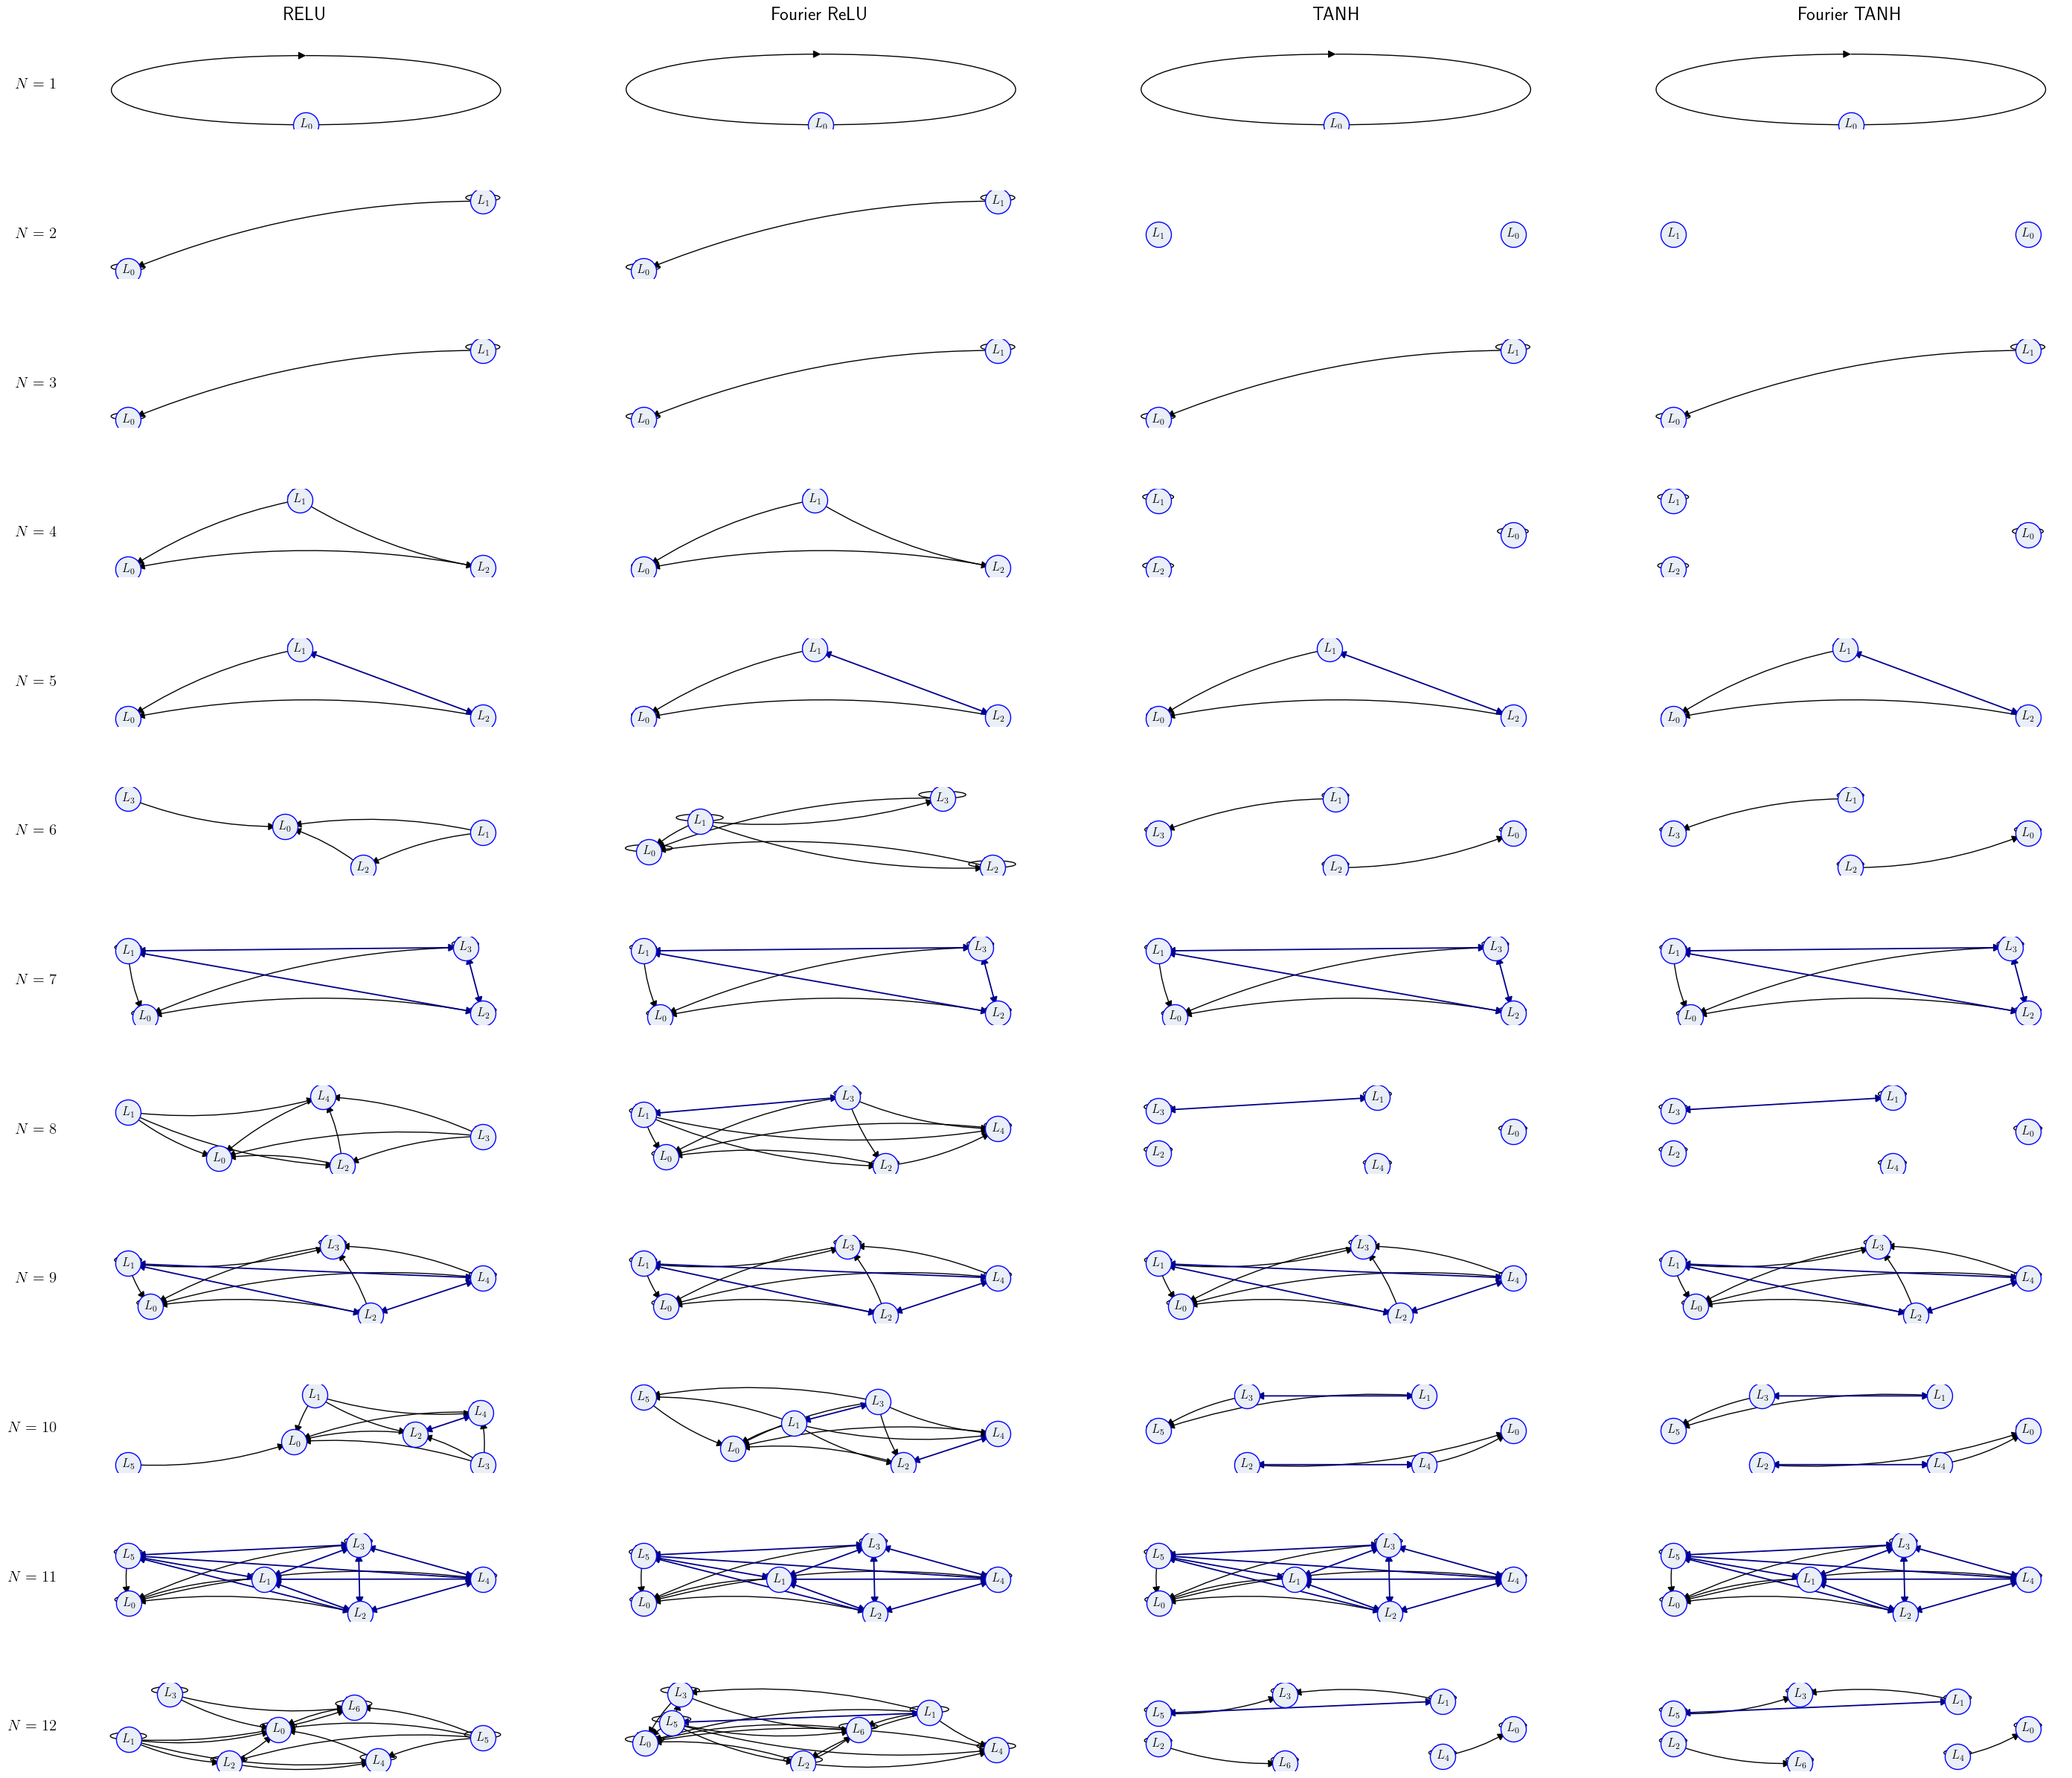

In [ ]:
N = 12
# activ_funcs = [LINEAR, RELU, ABS, GELU, BINARY, SIGMOID, TANH, SOFTSIGN, SOFTPLUS, LEAKY_RELU, SILU, ELISH, GAUSSIAN, SINUSOIDAL]
activ_funcs = [RELU, relu_fourier, TANH, tanh_fourier]
titles = ["ReLU", "Fourier ReLU", "TANH", "Fourier TANH"]

fig, axs = plt.subplots(N, len(activ_funcs),
                        figsize=(7*len(activ_funcs), 2*N),
                        constrained_layout=True)

# --- make axs always 2D ---
axs = np.atleast_2d(axs)
if axs.shape[0] == 1 and N > 1:      # single row
    axs = axs.T
# now axs[i, j] always works

for j, activ_func in enumerate(activ_funcs):
    for i, n in enumerate(range(1, N+1)):
        Q, labels = q_matrix(n)
        M = m_matrix(n)
        D = d_matrix(n)
        byL = indices_by_rep(labels)

        blocks = {}
        for Ls in byL:
            for Lk in byL:
                B = activation_func_block(Q, D, byL, Ls, Lk, activation_func=activ_func)
                if not is_zero_numeric(B, tol=1e-12):
                    blocks[(Ls, Lk)] = B

        ax = axs[i, j]
        intersection_graph(
            blocks,
            use_latex=True,
            title=None,
            layout="auto",
            ax=ax
        )

        ax.set_xticks([])
        ax.set_yticks([])
        for side in ("top", "right", "bottom", "left"):
            ax.spines[side].set_visible(False)

        if j == 0:
            ax.text(-0.08, 0.5, rf"$N={n}$", transform=ax.transAxes,
                    ha="right", va="center", fontsize=15)

        if titles is None:
            if i == 0:
                ax.set_title(f"{activ_func.__name__}", fontsize=18, pad=20)
        
        else:
            if i == 0:
                ax.set_title(titles[j], fontsize=18, pad=20)

plt.subplots_adjust(wspace=0.2, hspace=0.7)
plt.show()

In [56]:
n = 10
set(calculate_block(n, relu_fourier).keys()) - set(calculate_block(n, RELU).keys())

{('L_1', 'L_3'), ('L_1', 'L_5'), ('L_3', 'L_1'), ('L_3', 'L_5')}